# **Harmony**: Question Matching Algorithm Improvement Challenge

**NLP challenge** | [Visit the challenge page](https://doxaai.com/competition/harmony-matching)

Your challenge is to develop an improved algorithm for matching psychology survey questions that produces similarity ratings more closely aligned with those given by humans psychologists working in the field and that can be integrated into the [Harmony tool](https://harmonydata.ac.uk/developer-guide/).

This Jupyter notebook will introduce you to the challenge and guide you through the process of making your first submission to the [DOXA AI platform](https://doxaai.com/competition/harmony-matching).

**Before you get started, make sure to [sign up for an account](https://doxaai.com/sign-up) if you do not already have one and [enrol to take part](https://doxaai.com/competition/harmony-matching) in the challenge.**

**If you have any questions, feel free to ask them in the [Harmony community Discord server](https://discord.com/invite/harmonydata).**


## Installing and importing useful packages

Before you get started, please make sure you have [PyTorch](https://pytorch.org/get-started/locally/) installed in your Python environment. If you do not have `pandas`, `seaborn`, `transformers` or `sentence-transformers`, the code in the following cell will install them.


In [26]:
%pip install "pandas>=2.2.2" "seaborn>=0.13.2" "transformers>=4.43.1" "sentence-transformers>=3.0.1"

In [27]:
# Install the latest version of the DOXA CLI
%pip install -U doxa-cli

In [28]:
%pip install datasets

  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
Using cached requests-2.32.3-py3-none-any.whl (64 kB)
  Attempting uninstall: requests
    Found existing installation: requests 2.26.0
    Uninstalling requests-2.26.0:
      Successfully uninstalled requests-2.26.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
doxa-cli 0.1.8 requires requests~=2.26.0, but you have requests 2.32.3 which is incompatible.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
langsmith 0.2.3 requires requests-toolbelt<2.0.0,>=1.0.0, but you have requests-toolbelt 0.10.1 which is incompatible.


In [4]:
%pip install scikit-learn


In [29]:
import os

import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split

pd.set_option("display.max_colwidth", None)

## Loading the data


In [30]:
# Download the dataset if we do not already have it
if not os.path.exists("train.csv"):
    !curl https://raw.githubusercontent.com/DoxaAI/harmony-matching-getting-started/main/train.csv --output train.csv

if not os.path.exists("submission"):
    !curl https://raw.githubusercontent.com/DoxaAI/harmony-matching-getting-started/main/submission/competition.py --create-dirs --output submission/competition.py
    !curl https://raw.githubusercontent.com/DoxaAI/harmony-matching-getting-started/main/submission/doxa.yaml --output submission/doxa.yaml
    !curl https://raw.githubusercontent.com/DoxaAI/harmony-matching-getting-started/main/submission/run.py --output submission/run.py

# Load the data
df = pd.read_csv("train.csv")

## Exploring the data

Let's get started by taking a look at the training dataset, which contains the following data variables:

- `sentence_1` and `sentence_2`: a pair of English-language sentences drawn from psychology surveys
- `human_similarity`: the human-judged similarity of the two sentences (integers in the range `[0, 100]`)
- `cosine_from_harmony`: cosine similarity values currently generated by the Harmony tool, which are provided purely for reference and do not form part of the challenge


In [3]:
df

,sentence_1,sentence_2,human_similarity,cosine_from_harmony
0,Do you believe in telepathy (mind-reading)?,I believe that there are secret signs in the world if you just know how to look for them.,15,0.242434
1,"Irritable behavior, angry outbursts, or acting aggressively?",Felt “on edge”?,62,-0.325047
2,I have some eccentric (odd) habits.,I often have difficulty following what someone is saying to me.,0,0.441590
3,Do you often feel nervous when you are in a group of unfamiliar people?,Been easily annoyed by different things?,0,0.407776
4,Do you believe in telepathy (mind-reading)?,Most of the time I find it is very difficult to get my thoughts in order.,26,0.335685
...,...,...,...,...
2346,Little interest or pleasure in doing things,At times I have wondered if my body was really my own,0,0.233570
2347,"Feeling down, depressed, or hopeless?",I find that I am very often confused about what is going on around me.,0,0.377662
2348,Not being able to stop or control worrying?,"If given the choice, I would much rather be with another person than alone.",16,-0.170234
2349,"Feeling nervous, anxious or on edge?",Have had changes in appetite or sleep?,16,0.357956


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2351 entries, 0 to 2350
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sentence_1           2351 non-null   object 
 1   sentence_2           2351 non-null   object 
 2   human_similarity     2351 non-null   int64  
 3   cosine_from_harmony  2351 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 73.6+ KB


array([[<Axes: title={'center': 'human_similarity'}>,
        <Axes: title={'center': 'cosine_from_harmony'}>]], dtype=object)

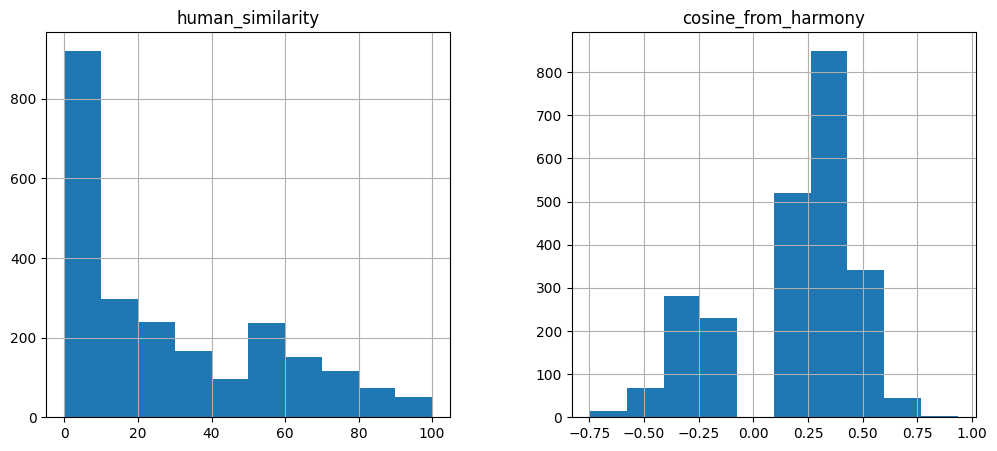

In [13]:
df.hist(figsize=(12, 5))

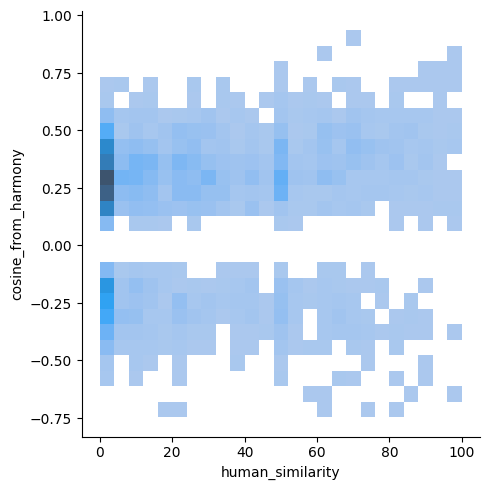

In [10]:
sns.displot(df, x="human_similarity", y="cosine_from_harmony", bins=25)

In [14]:
df[["human_similarity", "cosine_from_harmony"]].corr()

,human_similarity,cosine_from_harmony
human_similarity,1.000000,0.114113
cosine_from_harmony,0.114113,1.000000


As you can see from the visualisations and the correlation matrix, the cosine similarity scores currently being used within the Harmony tool do not correlate particularly well with the human-sourced similarity ratings. Your challenge is to develop a matching algorithm that aligns more closely with the human-provided scores!


## Generating embeddings

In this notebook, as an example to get you started, we are going to implement the relatively simple strategy of using a pre-trained model to compute sentence embeddings for each sentence in the training dataset and using the cosine similarity between the sentence pairs in the dataset as the basis for our similarity score predictions.

First, we will load a pre-trained [SentenceTransformers](https://sbert.net/) model:


In [31]:
import os

import pandas as pd
import seaborn as sns
from datasets import Dataset
from sentence_transformers import SentenceTransformer,SentenceTransformerTrainer,InputExample
from sentence_transformers.losses import CosineSimilarityLoss
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from torch.utils.data import DataLoader

pd.set_option("display.max_colwidth", None)

In [32]:
data=df.copy()
data['normalize_score']=data['human_similarity']/100
data.drop(columns=['cosine_from_harmony','human_similarity'],inplace=True,axis=1)
data['sentence_1']=data['sentence_1'].astype(str)
data['sentence_2']=data['sentence_2'].astype(str)

In [33]:
full_data=Dataset.from_pandas(data)
train=full_data.train_test_split(test_size=0.2)
train_data=[InputExample(texts=[row['sentence_1'],row['sentence_2']],label=row['normalize_score']) for row in train['train']]
train_data1=DataLoader(train_data,batch_size=16,shuffle=True)

Dataset({
    features: ['sentence_1', 'sentence_2', 'prediction', 'normalize_score'],
    num_rows: 1880
})

In [34]:
test_data=[InputExample(texts=[row['sentence_1'],row['sentence_2']],label=row['normalize_score']) for row in train['test']]
evaluator=EmbeddingSimilarityEvaluator.from_input_examples(test_data,batch_size=16)

In [35]:
model = SentenceTransformer("all-mpnet-base-v2")

model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

Next, we will use this to generate embeddings for all the sentence pairs in the training dataset and then compute the cosine similarity for each pair. Then, to produce similarity scores in the range `[0, 100]` to match the human-provided scores, we will slightly rescale and clip the cosine similarities we just computed.


In [36]:
loss=CosineSimilarityLoss(model=model)

In [ ]:
model.fit(train_objectives=[(train_data1,loss)],
          epochs=11,
          evaluator=evaluator,
          save_best_model=True,
          optimizer_params={'lr':0.001}
          )

Step,Training Loss,Validation Loss,Pearson Cosine,Spearman Cosine
118,No log,No log,0.305055,0.280175
236,No log,No log,0.327775,0.302919
354,No log,No log,0.289739,0.265783
472,No log,No log,0.309238,0.280261
500,0.029700,No Log,No Log,No Log
590,0.029700,No log,0.258876,0.240433


In [54]:
train_data=train['train']
test_data=train['test']

In [ ]:
sentences = list(set(train_data["sentence_1"]) | set(train_data["sentence_2"]))
embeddings = {
    sentence: embedding
    for sentence, embedding in zip(
        sentences, model.encode(sentences, batch_size=16, show_progress_bar=True)
    )
}

df["prediction"] = model.similarity_pairwise(
    df["sentence_1"].map(embeddings),
    df["sentence_2"].map(embeddings),
)
df["prediction"] = (100 * df["prediction"]).apply(int).clip(0, 100)

In [23]:
mean_absolute_error(train_data['human_similarity'],df['prediction'])

KeyError: "Column human_similarity not in the dataset. Current columns in the dataset: ['sentence_1', 'sentence_2', 'normalize_score']"

In [38]:
sentences = list(set(df["sentence_1"]) | set(df["sentence_2"]))
embeddings = {
    sentence: embedding
    for sentence, embedding in zip(
        sentences, model.encode(sentences, batch_size=16, show_progress_bar=True)
    )
}



df["prediction"] = model.similarity_pairwise(
    df["sentence_1"].map(embeddings),
    df["sentence_2"].map(embeddings),
)
df["similarity_prediction"] = (100 * df["prediction"]).apply(int).clip(0, 100)

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

In [58]:
sentences = list(set(df["sentence_1"]) | set(df["sentence_2"]))
embeddings = {
    sentence: embedding
    for sentence, embedding in zip(
        sentences, model.encode(sentences, batch_size=16, show_progress_bar=True)
    )
}
df['embeddings1']=df['sentence_1'].map(embeddings)
df['embeddings2']=df['sentence_2'].map(embeddings)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

In [37]:
df.index

RangeIndex(start=0, stop=2351, step=1)

In [59]:
embedding1_data=pd.DataFrame(df['embeddings1'].tolist(),index=df.index)
embedding2_data=pd.DataFrame(df['embeddings2'].tolist(),index=df.index)
embedding1_data.columns=[f'embedding1_{col}' for col in range(0,768)]
embedding2_data.columns=[f'embedding2_{col}' for col in range(0,768)]
new_data=pd.concat([df[['sentence_1','sentence_2','human_similarity']],embedding1_data,embedding2_data],axis=1)

In [60]:
X=new_data.drop(columns=['sentence_1','sentence_2','human_similarity'],axis=1)
y=new_data['human_similarity']

,0
embedding1_0,0.082964
embedding1_1,0.102516
embedding1_2,0.064965
embedding1_3,0.047266
embedding1_4,0.082856
...,...
embedding2_763,0.025938
embedding2_764,0.072590
embedding2_765,0.077666
embedding2_766,0.082361


In [61]:
X_train,X_test,Y_train,Y_test=train_test_split(X,y,test_size=0.2)

In [62]:
lr=LinearRegression()
lr.fit(X_train,Y_train)

LinearRegression()

In [63]:
Y_train_pred=lr.predict(X_train)
mean_absolute_error(Y_train,Y_train_pred)

21.25872230529785

In [64]:
Y_test_pred=lr.predict(X_test)
mean_absolute_error(Y_test,Y_test_pred)

24.052947998046875

In [75]:
sentences = list(set(df["sentence_1"]) | set(df["sentence_2"]))
embeddings = {
    sentence: embedding
    for sentence, embedding in zip(
        sentences, model.encode(sentences, batch_size=16, show_progress_bar=True)
    )
}

df["prediction"] = model.similarity_pairwise(
    df["sentence_1"].map(embeddings),
    df["sentence_2"].map(embeddings),
)
df["prediction"] = (100 * df["prediction"]).apply(int).clip(0, 100)


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

In [76]:
mean_absolute_error(df['human_similarity'],df['prediction'])

13.342832837090599

array([[<Axes: title={'center': 'human_similarity'}>,
        <Axes: title={'center': 'prediction'}>]], dtype=object)

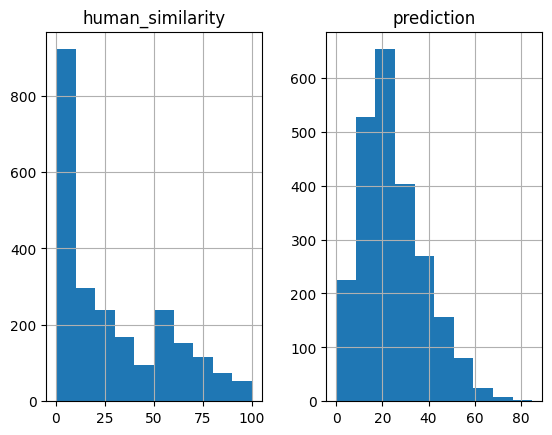

In [48]:
df.hist(["human_similarity", "prediction"])

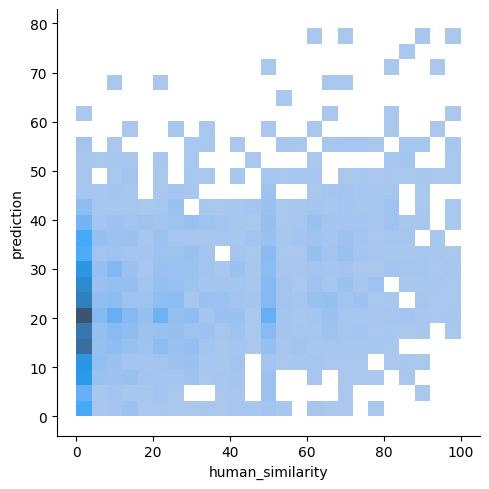

In [41]:
sns.displot(df, x="human_similarity", y="prediction", bins=25)

In [77]:
df[["human_similarity", "cosine_from_harmony", "prediction"]].corr()

,human_similarity,cosine_from_harmony,prediction
human_similarity,1.000000,0.114113,0.757923
cosine_from_harmony,0.114113,1.000000,0.157710
prediction,0.757923,0.157710,1.000000


While these predictions represent a slight improvement, it is now your challenge to see how much better you can make things! 👀


## Producing a submission package

**Now, we will move onto creating your first submission!**

When you upload your work to the DOXA AI platform, your code will be run in an environment with no internet access. As such, your submission needs to contain any models you want to use as part of the submission, as well as any code necessary to use those models.

Currently, the `submission/` folder contains three files:

- `submission/competition.py`: this contains competition-specific code used to interface with the platform
- `submission/doxa.yaml`: this is a configuration file used by the DOXA CLI when you make a submission
- `submission/run.py`: this is the Python script that gets run when your work gets evaluated (**you will need to edit this to implement your solution!**)

First, we will save the SentenceTransformer model we have just loaded into our `submission/` directory:


In [78]:
model.save("submission/model")

Next, if you take a look at `run.py`, you will see the following:

```py
class Evaluator(BaseEvaluator):
    def predict(self, df: pd.DataFrame) -> Generator[int, Any, None]:
        model = SentenceTransformer(str(directory / "model"))

        sentences = list(set(df["sentence_1"]) | set(df["sentence_2"]))
        embeddings = {
            sentence: embedding
            for sentence, embedding in zip(
                sentences, model.encode(sentences, batch_size=16)
            )
        }

        df["prediction"] = model.similarity_pairwise(
            df["sentence_1"].map(embeddings),
            df["sentence_2"].map(embeddings),
        )
        df["prediction"] = (100 * df["prediction"]).apply(int).clip(0, 100)

        for _, row in df.iterrows():
            yield row["prediction"]
```

In the `predict()` method, we load the `SentenceTransformer` model we just saved at `submission/model`, produce embeddings for the dataframe provided (in this instance containing the test set sentence pairs), compute the cosine similarities and then transform it into integer scores in the range `[0, 100]`. There are multiple ways to produce these similarity scores, and it is up to you to experiment with different techniques! For example, instead of computing the cosine similarity here, you may want to feed the embeddings you generate into another neural network you have trained for this task.

**When you come to implement your own solution, you will need to edit `predict()` in `run.py` and make sure you include the right model in your submission!**

You can modify `predict()` however you wish: it just has to yield your similarity score predictions in the same order as they appear in the dataframe. If your submission requires a lot of RAM, you may wish to modify `predict()` to process the test set in batches instead of all at once. Note that in addition to the RAM limit, there is a submission size limit, so make sure you are only uploading models that are relevant to your current submisison.


## Uploading your submission to the platform

You are now ready to make your first submission to the platform! 👀

**Make sure to [enrol to take part](https://doxaai.com/competition/harmony-matching) in the challenge if you have not already done so.**

First, we need to make sure we are logged in:


In [51]:
!doxa login


Use the link below to log into the CLI using your DOXA account:
	https://doxaai.com/oauth/device/nAMqjtxmOijg

The verification link has been opened in your default browser.

✔ Authorisation successful - you have now been logged in!


And then, we can submit our work for evaluation:


In [79]:
!doxa upload submission


  Compressing your submission ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100%      4/4 files

  Uploading your submission   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100%      405.4/405.4 MB      18.7 MB/s

  Your submission has been successfully uploaded to the DOXA AI platform!


**Congratulations!** 🥳

By this point, you will now have just made your first submission for this challenge on the DOXA AI platform!

If everything went well, your submission will now be queued up for evaluation. It will first be run on a small validation set to make sure that your submission does not crash on the full test set. If your submission runs into an issue at this point, you will be able to see the error logs from this phase. Otherwise, if your submission passes this stage, it will be evaluated on the full test set, and you will soon appear on the [competition scoreboard](https://doxaai.com/competition/harmony-matching/scoreboard)!


## Next steps

**Now, it is up to you as to where you go from here to solve this challenge!**

Here are some ideas you might want to test out:

- Using other [SentenceTransformers](https://sbert.net/) models that may perform better at this task than `all-mpnet-base-v2`
- Training an additional model to predict `human_similarity` from embeddings computed using the [SentenceTransformers](https://sbert.net/) library
- Fine-tuning a language model for this task

If you are new to fine-tuning language models, take a look at the excellent [HuggingFace `transformers` documentation](https://huggingface.co/docs/transformers/en/training)!

**We look forward to seeing what you build!** We would love to hear about what you are working on for this challenge, so do let us know how you are finding the challenge on the [Harmony community Discord server](https://discord.com/invite/harmonydata) or the [DOXA AI community Discord server](https://discord.gg/MUvbQ3UYcf). 😎
